In [1]:
from urllib.request import urlretrieve
import zipfile
import os

def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("")
    os.remove(zip_path)    

In [2]:
url = "https://storage.googleapis.com/kaggle-data-sets/3258/5337/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586457678&Signature=Fpk8Z%2BNCFNBkVKBztZZR5QHgmGBdfjXb6g3f8SWjGz8bXPgdh3jqslYfZ3EorgG6SvMcZ17OlGQ8zkrzWbGkN0Va5cHRVq5LYfDrJBw2rIbmaw3S4TUFR6XZTgwjmfIrD69G6w7Q1US4SydNmKb42Duf7pbP51VrK3RTPBHqowBvvM5wzQpkmDd6UMkIxKVltsZRtV%2F8SLuQKz%2BtUXP5dc88vXUU1M3REQ2NuFjrOakd3%2BINEzPnIDbIbpdedD4hFe95zBjNiMURqW4a8u4FplVVw9xI4ugdqOukzKC6pXnBetlgy5R0eyUJP2Udf63tp0s6NN%2FjOp8Clf5P9yOe%2FQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dsign-language-mnist.zip"
download_file(url, "sign-mnist")

In [56]:
import numpy as np

def read_images_and_labels(filename):
    images = []
    with open(filename) as f:
        f.readline() # read header
        for line in f:
            label, *values = line.strip().split(',')
            image = np.array([float(v) for v in values]) / 255
            image.resize((28, 28, 1))
            images.append((int(label), image))
            
    return images

In [69]:
test_images = read_images_and_labels("sign_mnist_test.csv")
train_images = read_images_and_labels("sign_mnist_train.csv")

train_len = len(train_images)
val_len = int(train_len * 0.05)
val_images = train_images[:val_len]
train_images = train_images[val_len:]

val_labels = [p[0] for p in val_images]
val_images = [p[1] for p in val_images]

train_labels = [p[0] for p in train_images]
train_images = [p[1] for p in train_images]

test_labels = [p[0] for p in test_images]
test_images = [p[1] for p in test_images]

In [76]:
classes = sorted(list(set(train_labels + val_labels + test_labels)))
num_classes = max(classes) + 1

In [94]:
image_gen_train = ImageDataGenerator(
 
)

image_gen_val = ImageDataGenerator(

)


train_data_gen = image_gen_train.flow(
    np.array(train_images), np.array(train_labels), 
    batch_size=64, shuffle=True)

val_data_gen = image_gen_train.flow(
    np.array(val_images), np.array(val_labels), 
    batch_size=64, shuffle=True)

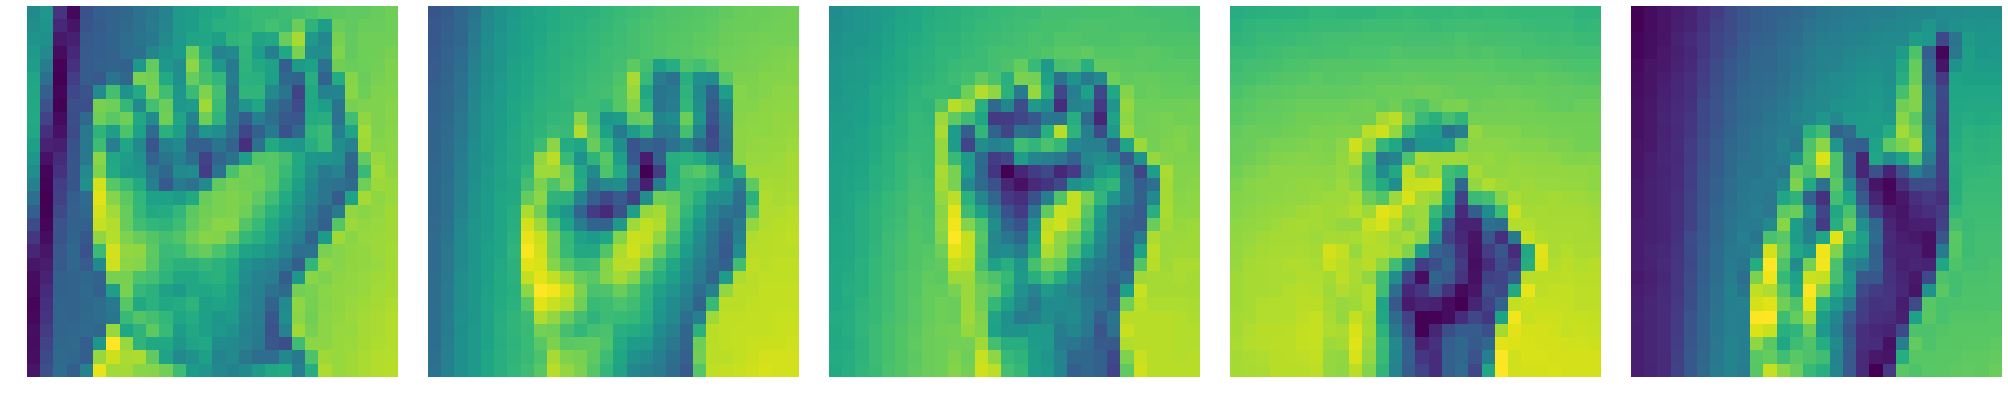

In [71]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(1, 5, figsize=(28,28))
axes = axes.flatten()
image_arr = [random.choice(train_images) for i in range(5)]
for img, ax in zip(image_arr, axes):
    img = np.array(img)
    img.resize((28, 28))
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [95]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, AveragePooling2D

input_images = Input(shape=(28, 28, 1,))
model = Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28, 28, 1), padding="same")(input_images)
model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(model)
model = Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid')(model)
model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(model)
model = Flatten()(model)
model = Dense(120, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(84, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input_images, model)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_23 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 120)               481

In [80]:
model.fit(np.array(train_images), np.array(train_labels), epochs=15, validation_data=(np.array(val_images), np.array(val_labels)), batch_size=128)

Train on 26083 samples, validate on 1372 samples
Epoch 1/15
26083/26083 [==============================] - 12s 479us/sample - loss: 2.4861 - accuracy: 0.2369 - val_loss: 1.3560 - val_accuracy: 0.6159
Epoch 2/15
26083/26083 [==============================] - 11s 440us/sample - loss: 1.4897 - accuracy: 0.5158 - val_loss: 0.8018 - val_accuracy: 0.7733
Epoch 3/15
26083/26083 [==============================] - 11s 436us/sample - loss: 1.1338 - accuracy: 0.6216 - val_loss: 0.5525 - val_accuracy: 0.8542
Epoch 4/15
26083/26083 [==============================] - 11s 433us/sample - loss: 0.9542 - accuracy: 0.6780 - val_loss: 0.4206 - val_accuracy: 0.8972
Epoch 5/15
26083/26083 [==============================] - 11s 439us/sample - loss: 0.8141 - accuracy: 0.7233 - val_loss: 0.3253 - val_accuracy: 0.9198
Epoch 6/15
26083/26083 [==============================] - 11s 439us/sample - loss: 0.7301 - accuracy: 0.7473 - val_loss: 0.2592 - val_accuracy: 0.9468
Epoch 7/15
26083/26083 [=====================

In [96]:
model.fit_generator(train_data_gen, epochs=15, validation_data=val_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 408 steps, validate for 22 steps
Epoch 1/15
408/408 [==============================] - 70s 171ms/step - loss: 2.3403 - accuracy: 0.2784 - val_loss: 1.1153 - val_accuracy: 0.6771
Epoch 2/15
408/408 [==============================] - 67s 164ms/step - loss: 1.3130 - accuracy: 0.5662 - val_loss: 0.6242 - val_accuracy: 0.8287
Epoch 3/15
408/408 [==============================] - 67s 164ms/step - loss: 0.9888 - accuracy: 0.6700 - val_loss: 0.4270 - val_accuracy: 0.9052
Epoch 4/15
408/408 [==============================] - 67s 163ms/step - loss: 0.8046 - accuracy: 0.7292 - val_loss: 0.3180 - val_accuracy: 0.9395
Epoch 5/15
408/408 [==============================] - 67s 164ms/step - loss: 0.6865 - accuracy: 0.7656 - val_loss: 0.2298 - val_accuracy: 0.9679
Epoch 6/15
408/408 [==============================] - 67s 163ms/step - loss: 0.6024 - accuracy: 0.7948 - val_loss: 0.1659 - val_accuracy: 0.9738
Epoch 7/15
408/408 [=================

In [97]:
model.evaluate(np.array(test_images), np.array(test_labels))

7172/7172 [==============================] - 5s 658us/sample - loss: 0.5293 - accuracy: 0.8586


[0.5292859370770879, 0.8586168]

In [87]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(28,28))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = np.array(img)
        img.resize(28, 28)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_gen_train = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

image_gen_val = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)


train_data_gen = image_gen_train.flow(
    np.array(train_images), np.array(train_labels), 
    batch_size=64, shuffle=True)

val_data_gen = image_gen_train.flow(
    np.array(val_images), np.array(val_labels), 
    batch_size=64, shuffle=True)

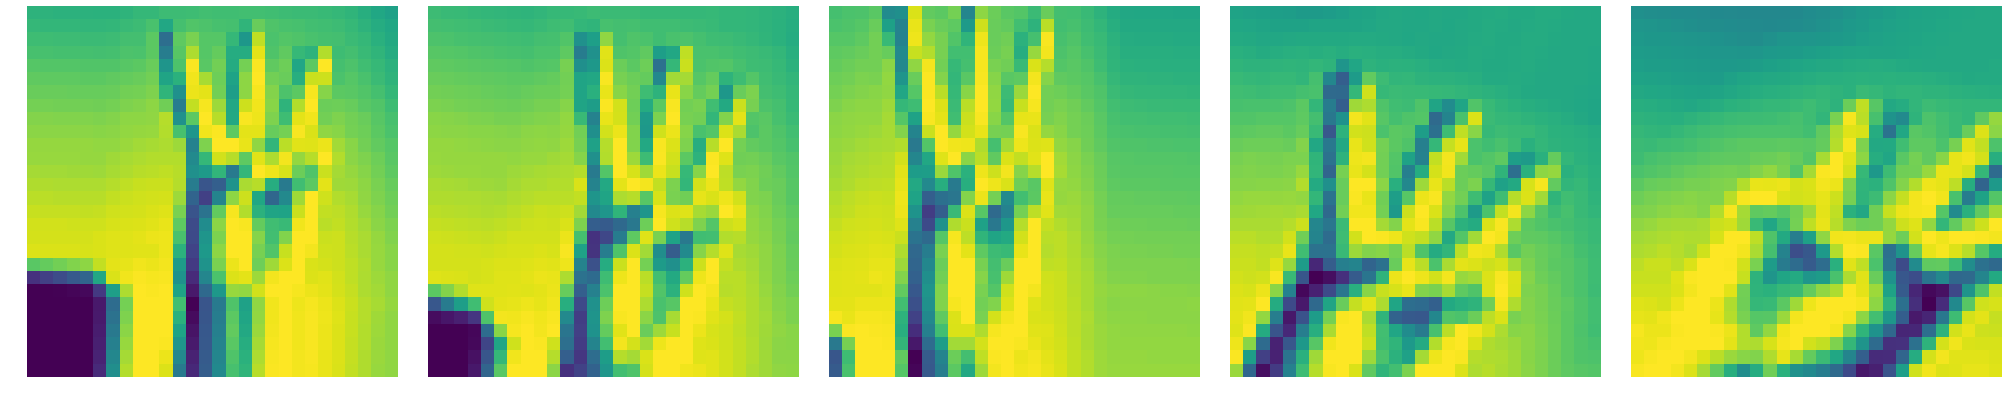

In [99]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [100]:
input_images = Input(shape=(28, 28, 1,))
model = Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28, 28, 1), padding="same")(input_images)
model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(model)
model = Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid')(model)
model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(model)
model = Flatten()(model)
model = Dense(120, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(84, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input_images, model)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_24 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_25 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 120)               481

In [101]:
model.fit_generator(train_data_gen, epochs=15, validation_data=val_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 408 steps, validate for 22 steps
Epoch 1/15
408/408 [==============================] - 64s 156ms/step - loss: 3.1276 - accuracy: 0.0695 - val_loss: 2.9303 - val_accuracy: 0.1305
Epoch 2/15
408/408 [==============================] - 49s 119ms/step - loss: 2.9264 - accuracy: 0.1136 - val_loss: 2.7744 - val_accuracy: 0.1567
Epoch 3/15
408/408 [==============================] - 63s 154ms/step - loss: 2.8454 - accuracy: 0.1341 - val_loss: 2.6829 - val_accuracy: 0.1851
Epoch 4/15
408/408 [==============================] - 87s 214ms/step - loss: 2.7881 - accuracy: 0.1498 - val_loss: 2.5933 - val_accuracy: 0.2026
Epoch 5/15
408/408 [==============================] - 83s 203ms/step - loss: 2.7524 - accuracy: 0.1568 - val_loss: 2.6286 - val_accuracy: 0.2055
Epoch 6/15
408/408 [==============================] - 82s 202ms/step - loss: 2.7193 - accuracy: 0.1644 - val_loss: 2.5650 - val_accuracy: 0.2048
Epoch 7/15
408/408 [=================